In [1]:
import torch
import time
from tqdm.notebook import tqdm
import sys
from LogSinkhornGPU import *
import pykeops
import numpy as np
import matplotlib.pyplot as plt

[KeOps] Compiling cuda jit compiler engine ... OK
[pyKeOps] Compiling nvrtc binder for python ... OK


In [2]:
M = N = 32
muref = torch.ones(1, M, device="cuda")
nuref = torch.ones(1, N, device="cuda")
muref = muref/torch.sum(muref, dim=1, keepdim=True)
nuref = nuref/torch.sum(nuref, dim=1, keepdim=True)
x = torch.linspace(0, 1, M, device="cuda")
y = torch.linspace(0, 1, N, device="cuda")

pi0 = torch.ones((M, N), device="cuda") / (M*N) # prod initialization

In [3]:
# Create partitions
partA = [[i, i+1] for i in range(0, N, 2)]
partB = [[0], *[[i, i+1] for i in range(1, N-2, 2)], [N-1]]

print(f'A has {len(partA)} cells:\n', partA)
print(f'B has {len(partB)} cells:\n', partB)

A has 16 cells:
 [[0, 1], [2, 3], [4, 5], [6, 7], [8, 9], [10, 11], [12, 13], [14, 15], [16, 17], [18, 19], [20, 21], [22, 23], [24, 25], [26, 27], [28, 29], [30, 31]]
B has 17 cells:
 [[0], [1, 2], [3, 4], [5, 6], [7, 8], [9, 10], [11, 12], [13, 14], [15, 16], [17, 18], [19, 20], [21, 22], [23, 24], [25, 26], [27, 28], [29, 30], [31]]


In [4]:
def batch_iteration(pi, x, y, muref, nuref, eps, part):
    # Get maximum size of cell marginals
    B = len(part)
    max_size = np.max(list(map(len, part)))
    Mu = torch.zeros((B, max_size), device="cuda")
    Muref = torch.zeros((B, max_size), device="cuda")
    Nu = torch.zeros((B, len(y)), device="cuda")
    Nuref = torch.zeros((B, len(y)), device="cuda")
    C = torch.zeros((B, max_size, len(y)), device="cuda")
    # Batch problems
    for (i, J) in enumerate(part):
        piJ = pi[J, :]
        xJ = x[J]
        muJ = torch.sum(piJ, dim=1).ravel()
        nuJ = torch.sum(piJ, dim=0).ravel()
        Mu[i, :len(J)] = muJ
        Nu[i, :] = nuJ
        Muref[i, :len(J)] = muref[0,J] # This might be different in the unbalanced case
        Nuref[i, :] = nuref[0,:]
        C[i, :len(J), :] = (xJ.reshape(-1,1) - y.reshape(1,-1))**2
    solver = LogSinkhornTorch(Mu, Nu, C, eps, muref=Muref, nuref=Nuref)

    solver.iterate_until_max_error()
    # Retrieve solution
    pi_batch = solver.get_pi_dense()
    pi_new = torch.zeros_like(pi)
    for (i, J) in enumerate(part):
        pi_new[J,:] = pi_batch[i, :len(J), :]
    return pi_new

0it [00:00, ?it/s]

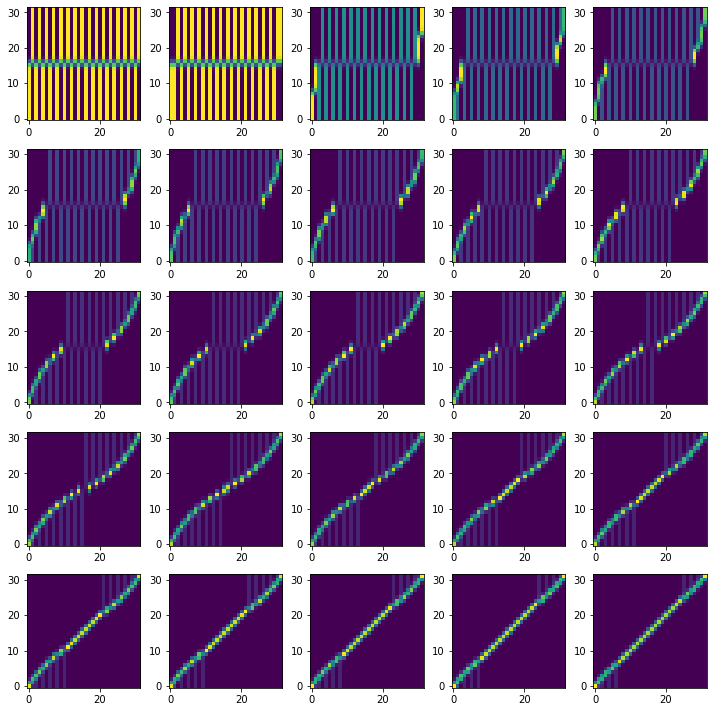

time = 2.4552s


In [5]:
t0 = time.perf_counter()

pi = pi0.clone()
# pi = torch.fliplr(torch.eye(M, device='cuda'))/M
eps = 1/M**2

n_iter = 25

cols = 5
rows = (n_iter-1)//cols + 1
fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(2*cols, 2*rows))

for i, ax in tqdm(enumerate(axs.flatten())):
    part = partA if i%2 == 0 else partB
    pi = batch_iteration(pi, x, y, muref, nuref, eps, part)
    ax.imshow(pi.cpu().detach().T, origin="lower")

plt.tight_layout()
plt.show()

t1 = time.perf_counter()
print(f'time = {t1-t0:.4f}s')